In [1]:
import sys
root_dir_abspath = '/home/adnen.boumessouer/LEGO-Anomaly-Detection'

In [2]:
sys.path.insert(0, root_dir_abspath)

In [3]:
import os
from pathlib import Path

import tensorflow as tf
# import skimage
from skimage.util import img_as_ubyte

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import argparse
import time

from processing.preprocessing import Preprocessor
from processing.preprocessing import get_preprocessing_function
from processing import utils
from processing import postprocessing

from processing.postprocessing import calculate_resmaps

# Load CAE

In [4]:
model_path ="saved_models/LEGO_light/SV/baselineCAE/mssim/21-09-2020_10-02-21/baselineCAE_b8_e181.hdf5"

In [5]:
# load model and info
model, info, _ = utils.load_model_HDF5(model_path)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [6]:
# set parameters
input_directory = info["data"]["input_directory"]
architecture = info["model"]["architecture"]
loss = info["model"]["loss"]
rescale = info["preprocessing"]["rescale"]
shape = info["preprocessing"]["shape"]
color_mode = info["preprocessing"]["color_mode"]
vmin = info["preprocessing"]["vmin"]
vmax = info["preprocessing"]["vmax"]
nb_validation_images = info["data"]["nb_validation_images"]

In [7]:
# get the correct preprocessing function
preprocessing_function = info["preprocessing"]["preprocessing"]

In [8]:
info

{'data': {'input_directory': 'LEGO_light/SV',
  'nb_training_images': 252,
  'nb_validation_images': 36,
  'validation_split': 0.0},
 'model': {'architecture': 'baselineCAE', 'loss': 'mssim'},
 'preprocessing': {'color_mode': 'rgb',
  'rescale': 0.00392156862745098,
  'shape': [256, 256],
  'vmin': 0.0,
  'vmax': 1.0,
  'dynamic_range': 1.0,
  'preprocessing': None},
 'lr_finder': {'lr_base': 0.0006897784187458456,
  'lr_opt': 0.00669586006551981},
 'training': {'batch_size': 8,
  'epochs_trained': 181,
  'nb_train_images_total': 45612}}

# Validation

## Compute Reconstructions

In [9]:
# initialize preprocessor
preprocessor = Preprocessor(
    input_directory=input_directory,
    rescale=rescale,
    shape=shape,
    color_mode=color_mode,
    preprocessing_function=preprocessing_function,)

In [10]:
# get validation generator
validation_generator = preprocessor.get_val_generator(
    batch_size=nb_validation_images, shuffle=True)

Found 36 images belonging to 1 classes.


In [11]:
# retrieve validation images from generator
imgs_val_input = validation_generator.next()[0]

In [12]:
# display shape
imgs_val_input.shape

(36, 256, 256, 3)

In [13]:
# retrieve validation image names
filenames_val = validation_generator.filenames

In [14]:
# get reconstructed images (i.e predictions) on validation dataset
imgs_val_pred = model.predict(imgs_val_input, verbose=1)

36/36 [==============================] - 3s 90ms/sample


In [15]:
# display shape
imgs_val_pred.shape

(36, 256, 256, 3)

## Plot Original, Reconstructed and Resmap Images (VALIDATION)

In [16]:
tensor_val_ssim = postprocessing.TensorImages(
                imgs_input=imgs_val_input,
                imgs_pred=imgs_val_pred,
                vmin=vmin,
                vmax=vmax,
                method="ssim",
                dtype="float64",
                filenames=filenames_val)

In [17]:
tensor_val_l2 = postprocessing.TensorImages(
                imgs_input=imgs_val_input,
                imgs_pred=imgs_val_pred,
                vmin=vmin,
                vmax=vmax,
                method="l2",
                dtype="float64",
                filenames=filenames_val)

In [18]:
list_val_good_sv = [
    "good/004.png",
    "good/104.png",
    "good/154.png",
    "good/204.png",
    "good/304.png",
    ]

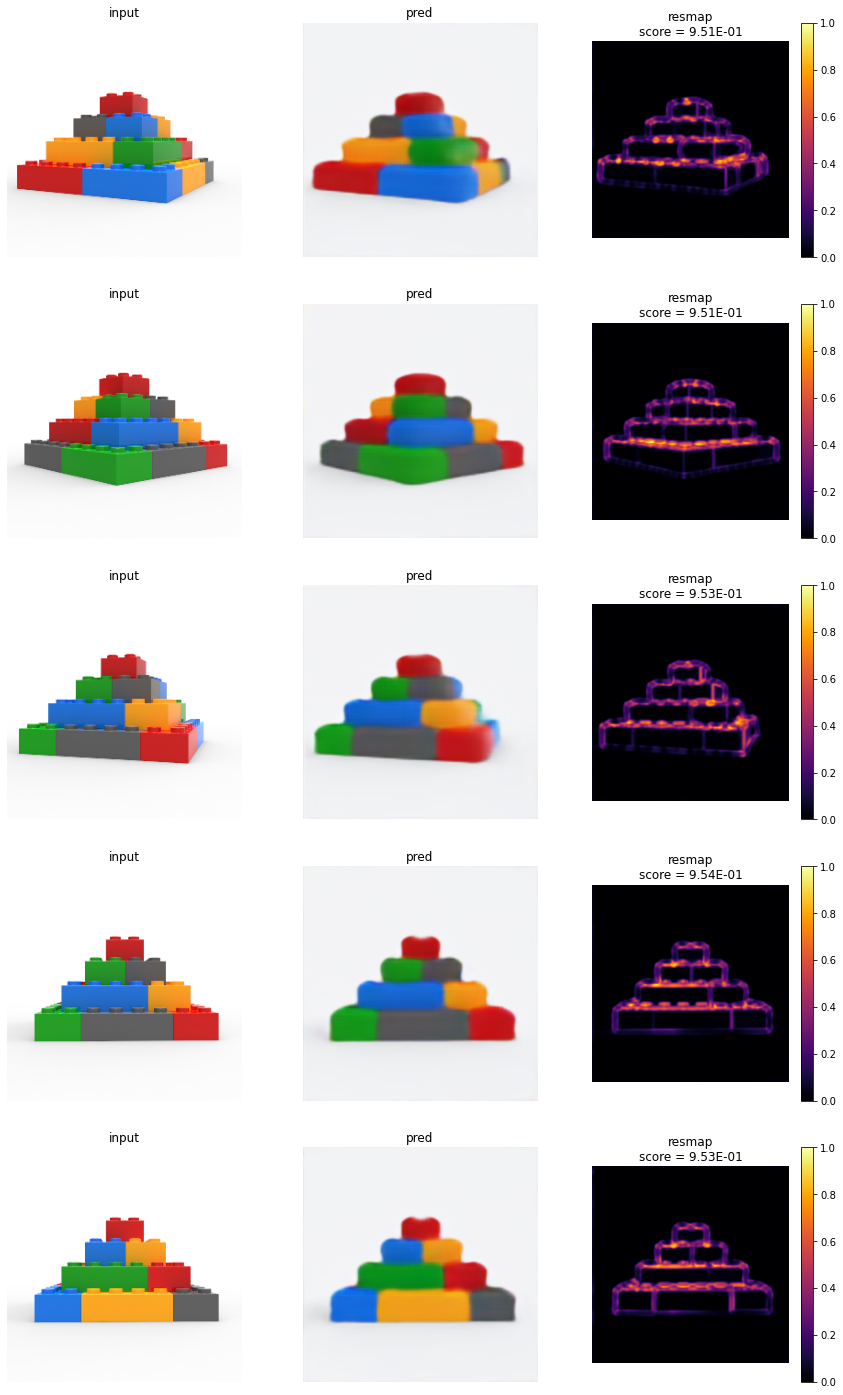

In [19]:
tensor_val_ssim.generate_inspection_figure(filenames_plot=list_val_good_sv)

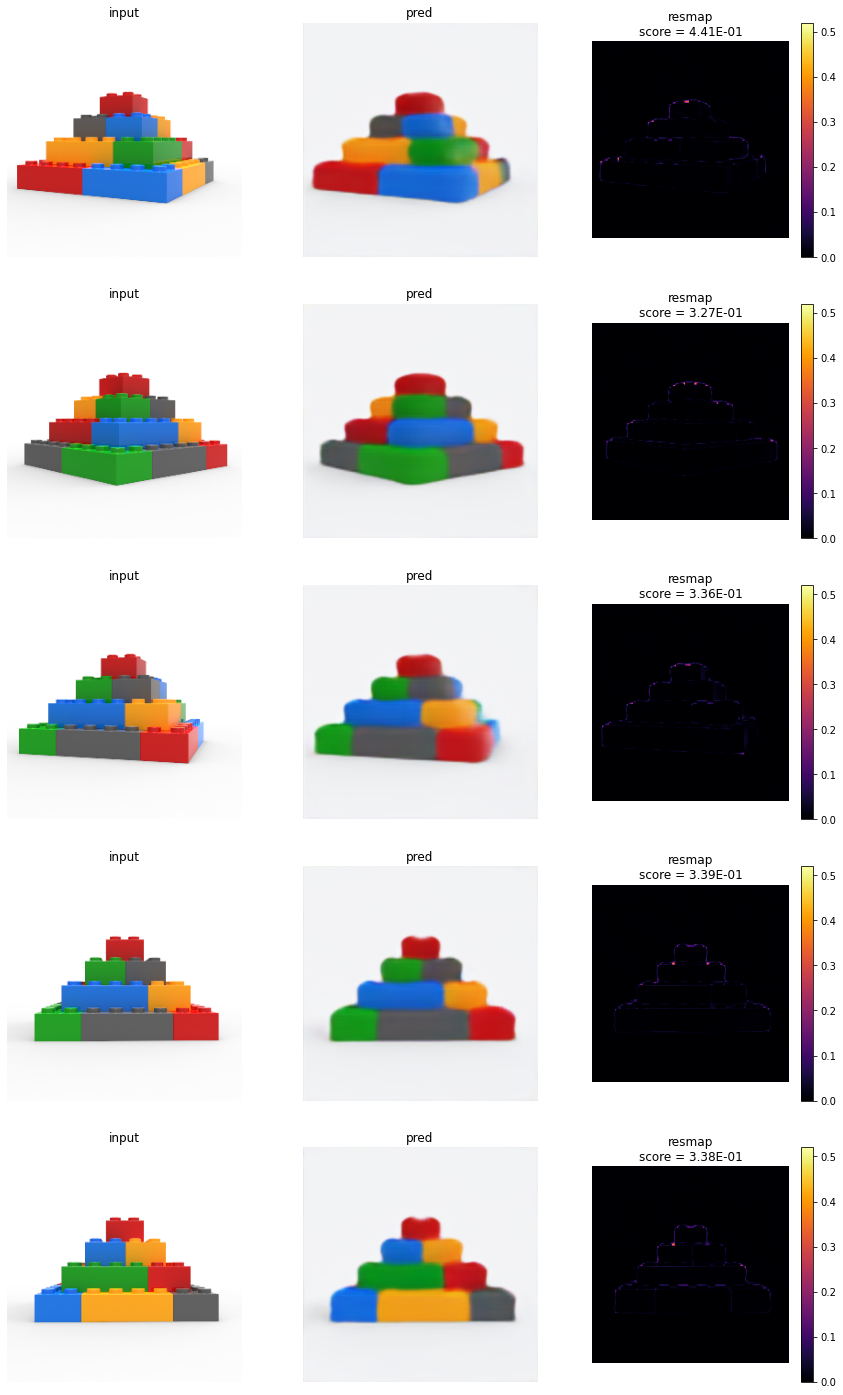

In [20]:
tensor_val_l2.generate_inspection_figure(filenames_plot=list_val_good_sv)

# Test Images

## Compute Reconstructions

In [21]:
# get test generator
nb_test_images = preprocessor.get_total_number_test_images()
test_generator = preprocessor.get_test_generator(batch_size=nb_test_images, shuffle=False)

Found 497 images belonging to 7 classes.


In [22]:
# retrieve validation images from generator
imgs_test_input = test_generator.next()[0]

In [23]:
# display shape
imgs_test_input.shape

(497, 256, 256, 3)

In [24]:
# retrieve test image names
filenames_test = test_generator.filenames

In [25]:
# get reconstructed images (i.e predictions) on test dataset
imgs_test_pred = model.predict(imgs_test_input, verbose=1)

497/497 [==============================] - 2s 3ms/sample


In [26]:
# display shape
imgs_test_pred.shape

(497, 256, 256, 3)

## Plot Original, Reconstructed and Resmap Images (TEST)

In [27]:
tensor_test_ssim = postprocessing.TensorImages(
                imgs_input=imgs_test_input,
                imgs_pred=imgs_test_pred,
                vmin=vmin,
                vmax=vmax,
                method="ssim",
                dtype="float64",
                filenames=filenames_test)

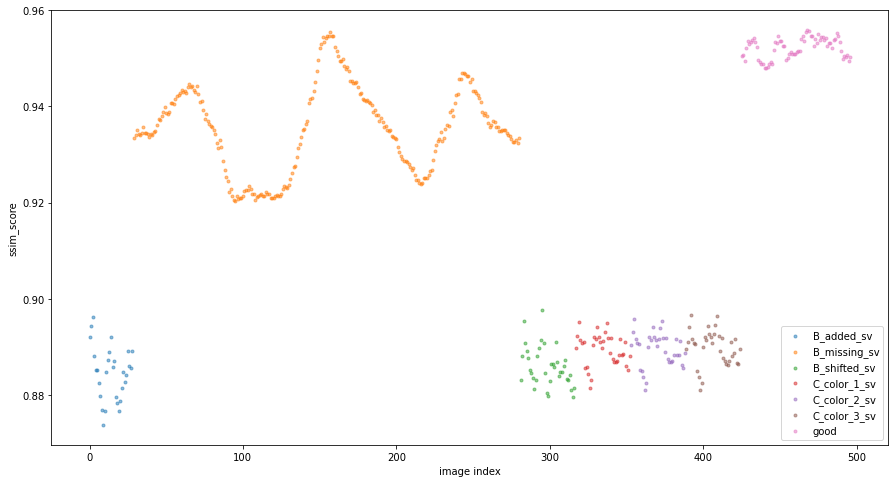

In [28]:
tensor_test_ssim.generate_score_scatter_plot(test_generator)

In [29]:
tensor_test_l2 = postprocessing.TensorImages(
                imgs_input=imgs_test_input,
                imgs_pred=imgs_test_pred,
                vmin=vmin,
                vmax=vmax,
                method="l2",
                dtype="float64",
                filenames=filenames_test)

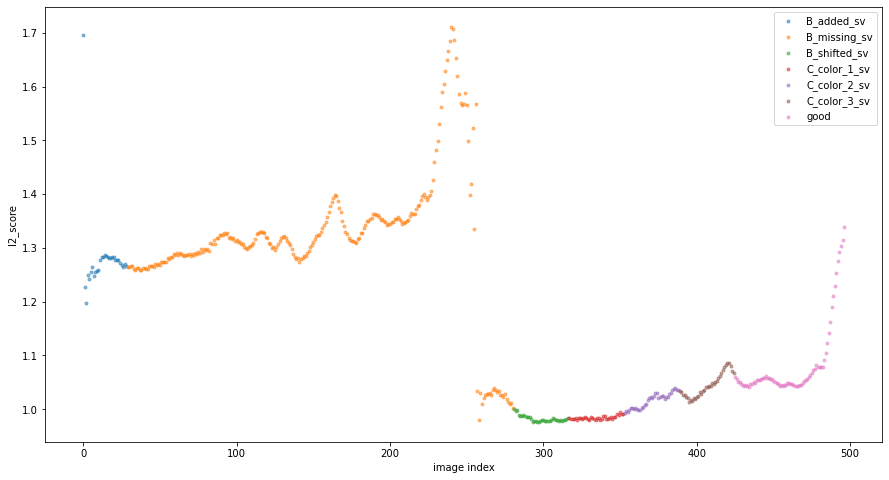

In [30]:
tensor_test_l2.generate_score_scatter_plot(test_generator)

### Anomaly-Free Test Images

In [31]:
list_test_good_sv = [
    "good/010.png",
    "good/055.png",
    "good/080.png",
    "good/120.png",
    "good/240.png",  
]

### SSIM

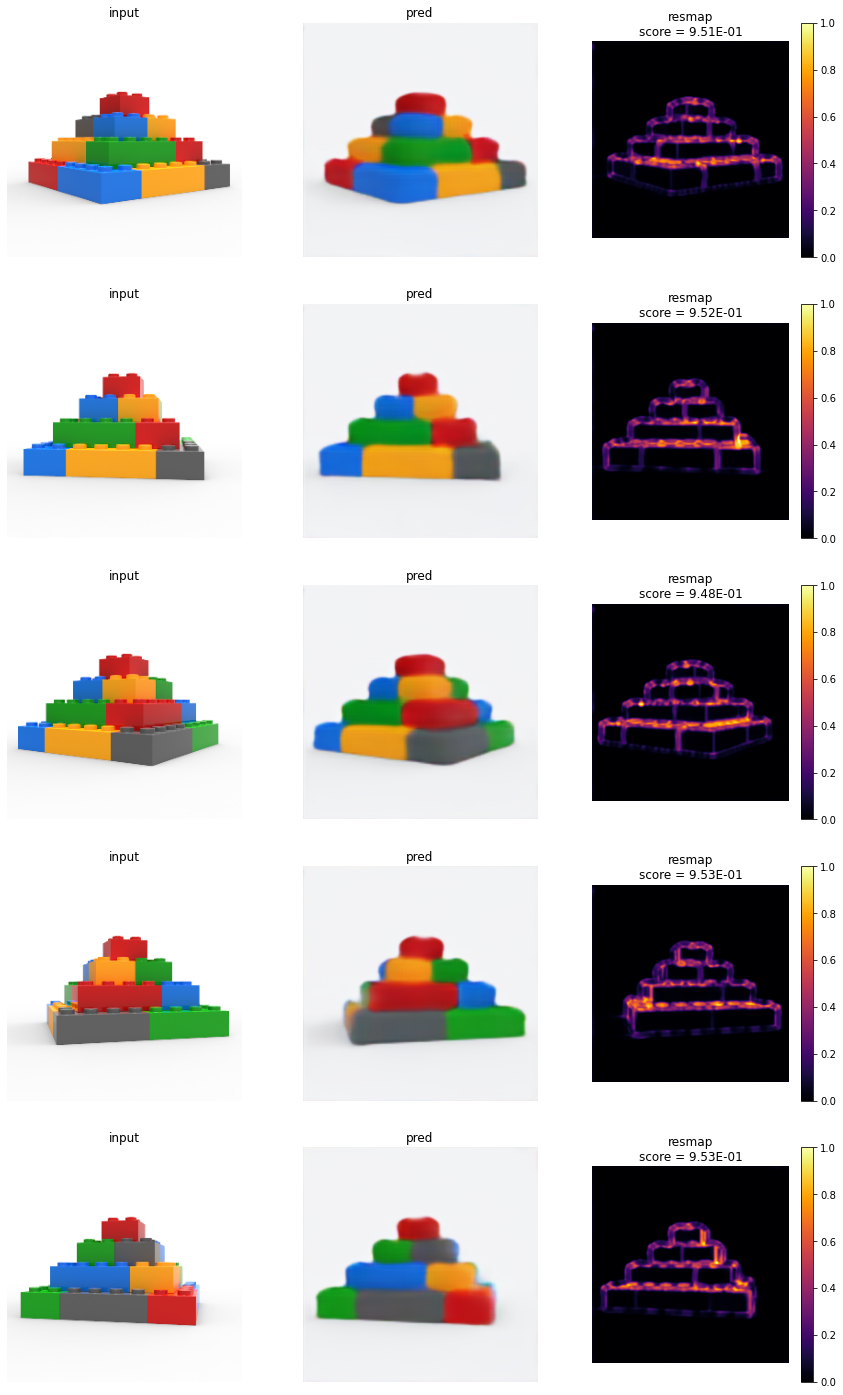

In [32]:
tensor_test_ssim.generate_inspection_figure(filenames_plot=list_test_good_sv)

### L2

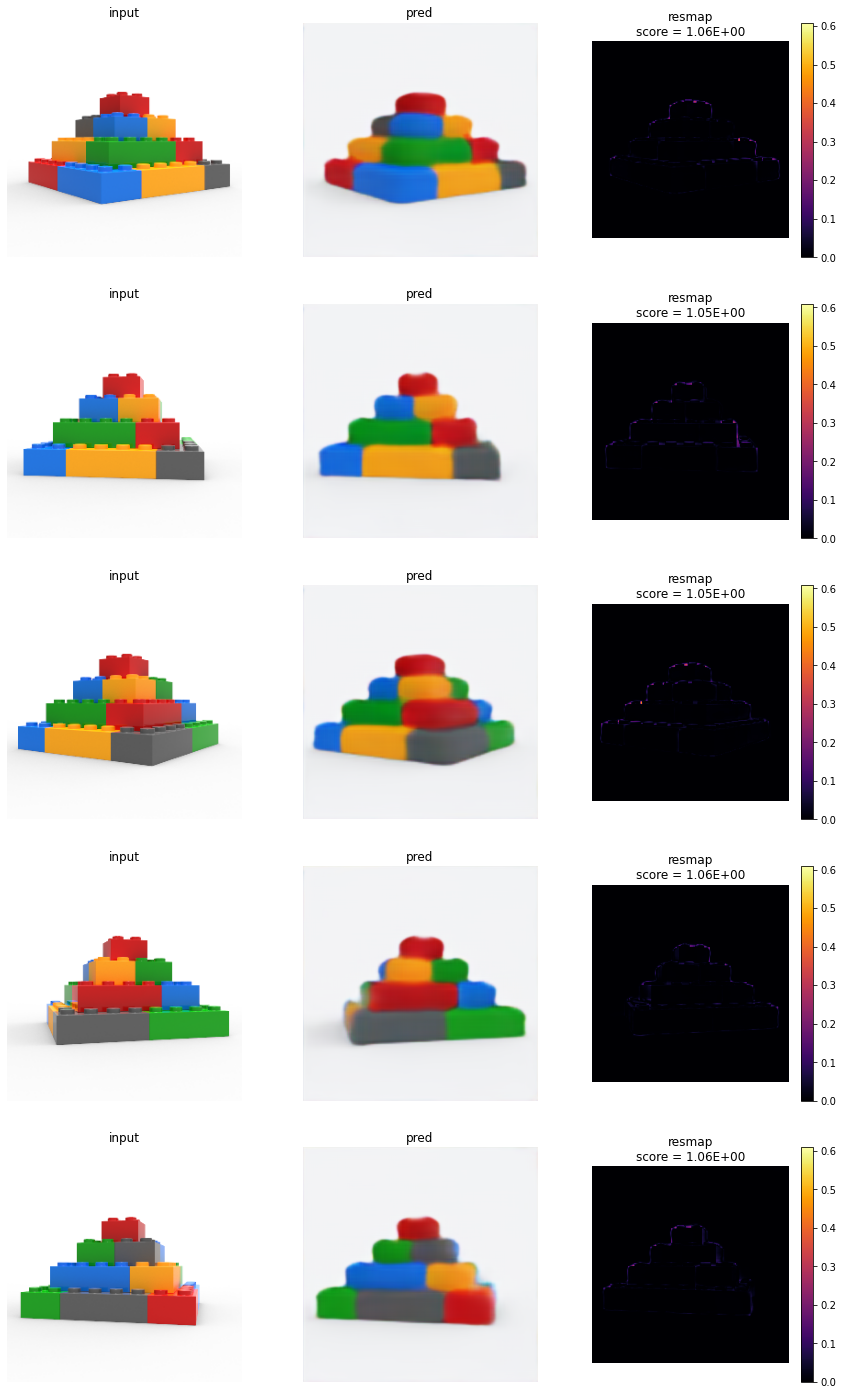

In [33]:
tensor_test_l2.generate_inspection_figure(filenames_plot=list_test_good_sv)

### Anomaly type: added Lego-Brick

In [35]:
list_B_added_sv = [
    "B_added_sv/020.png",
    "B_added_sv/040.png",
    "B_added_sv/080.png",
    "B_added_sv/090.png",
    "B_added_sv/120.png",
    "B_added_sv/230.png",
]

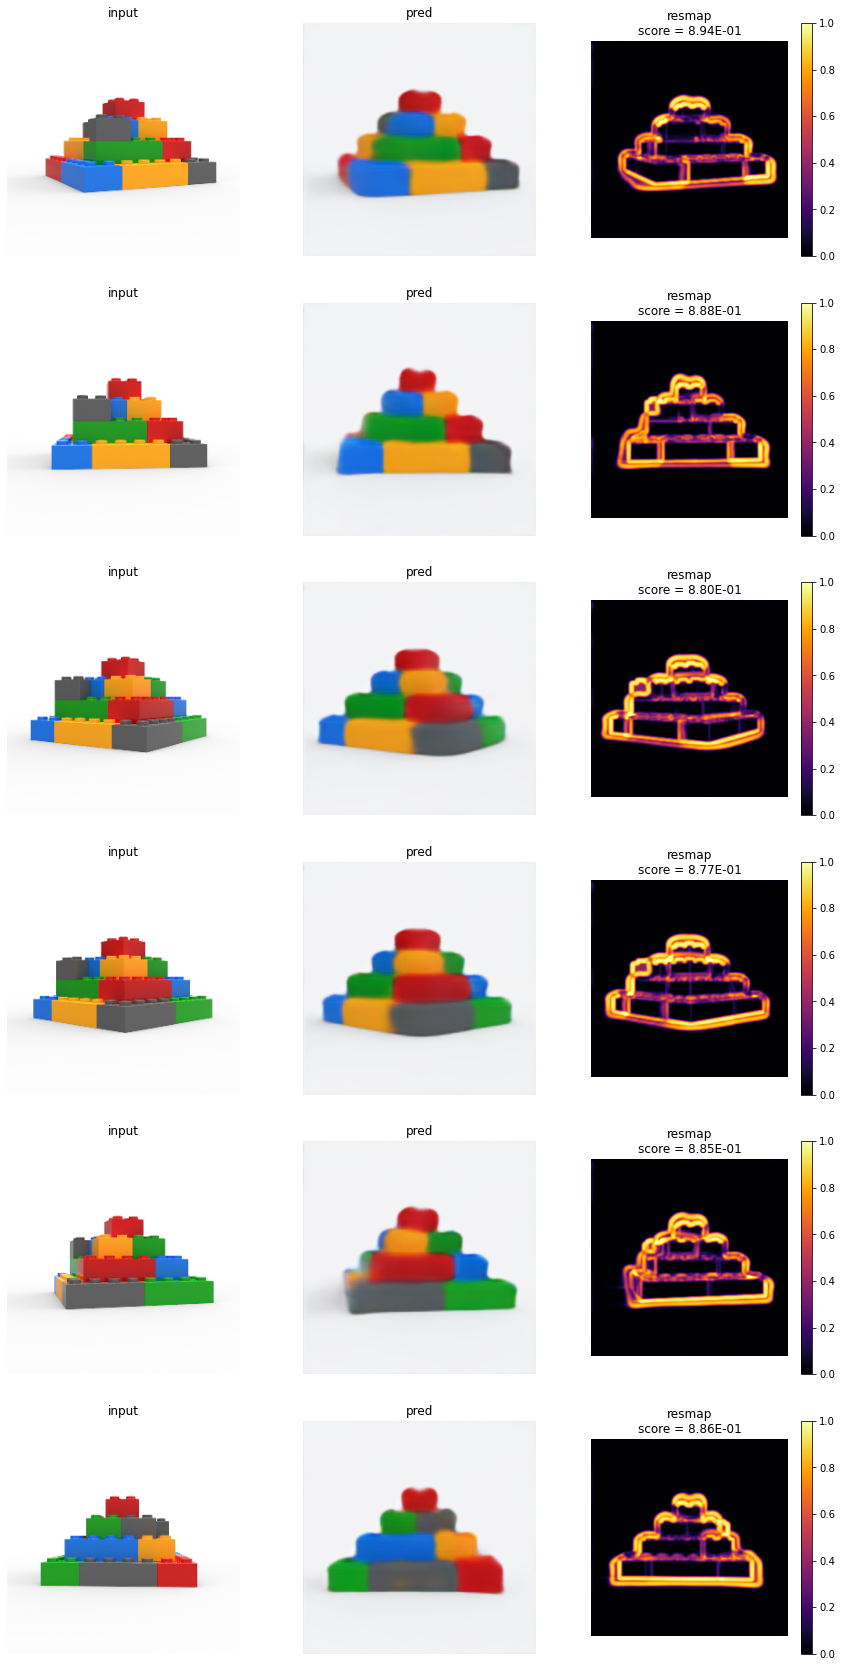

In [36]:
tensor_test_ssim.generate_inspection_figure(filenames_plot=list_B_added_sv)

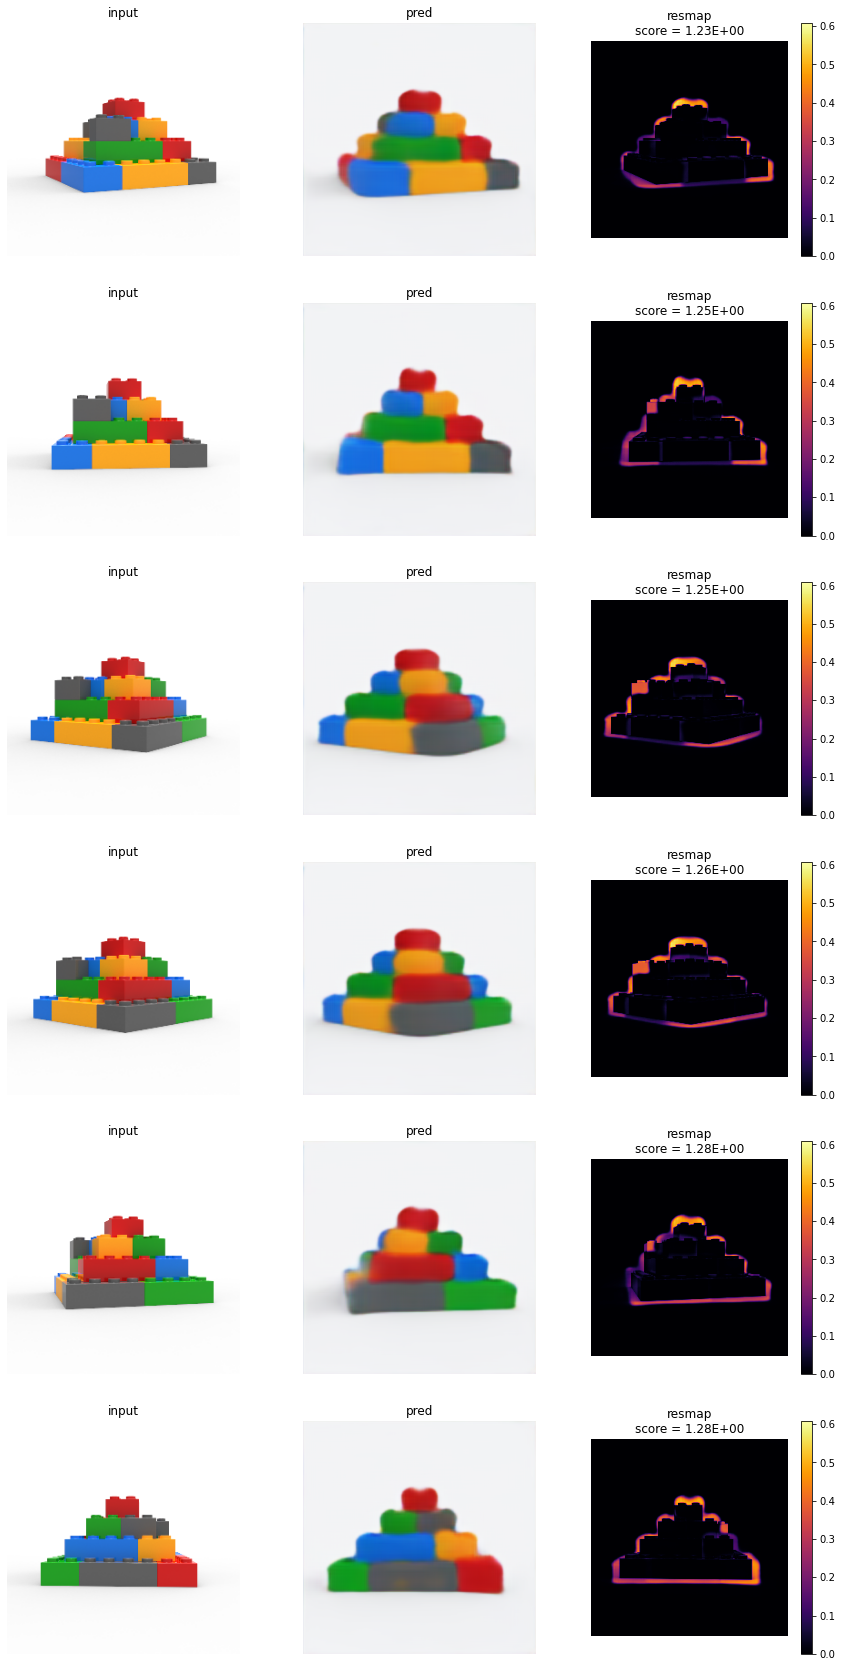

In [37]:
tensor_test_l2.generate_inspection_figure(filenames_plot=list_B_added_sv)

### Anomaly type: missing Lego-Brick

In [38]:
list_B_missing_sv = [
    "B_missing_sv/010.png",
    "B_missing_sv/020.png",
    "B_missing_sv/030.png",
    "B_missing_sv/040.png",
    "B_missing_sv/080.png",
    "B_missing_sv/100.png",
    "B_missing_sv/110.png",
    "B_missing_sv/260.png",
    "B_missing_sv/270.png",
    "B_missing_sv/320.png",
]

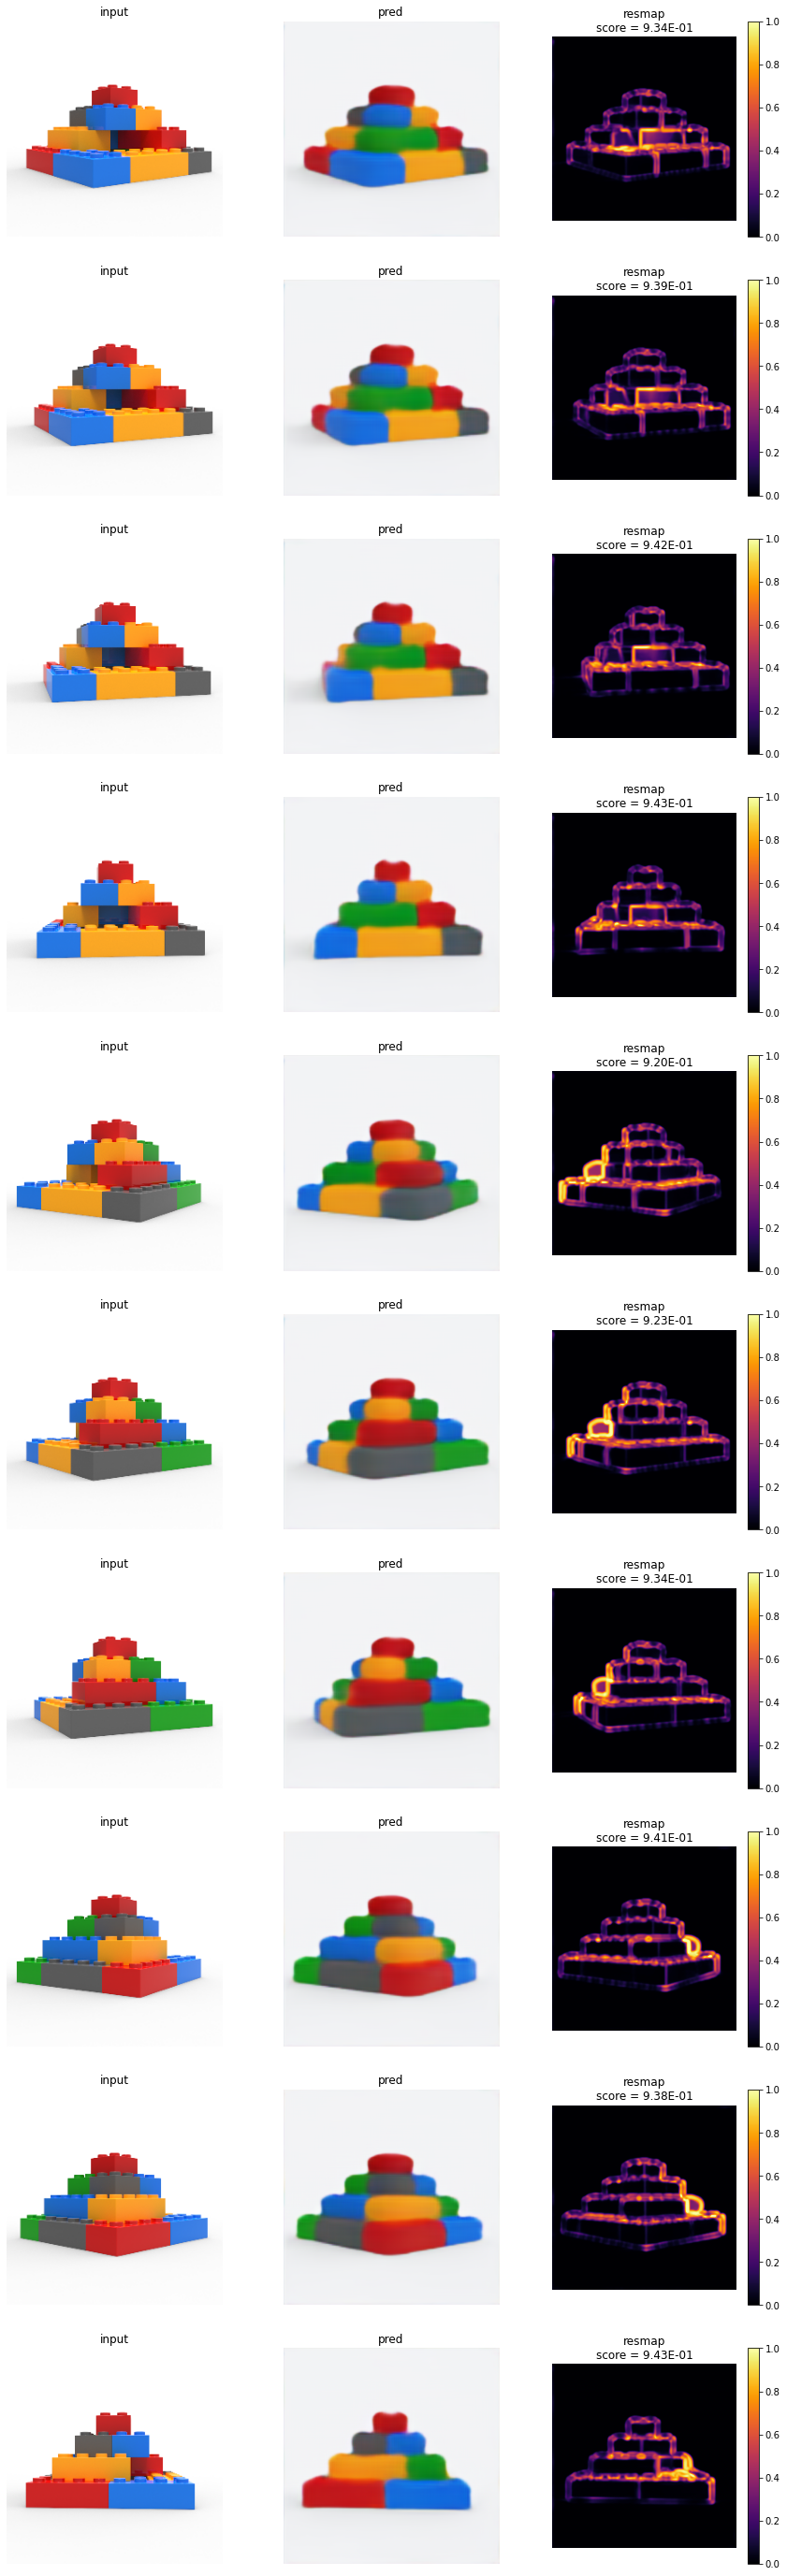

In [39]:
tensor_test_ssim.generate_inspection_figure(filenames_plot=list_B_missing_sv)

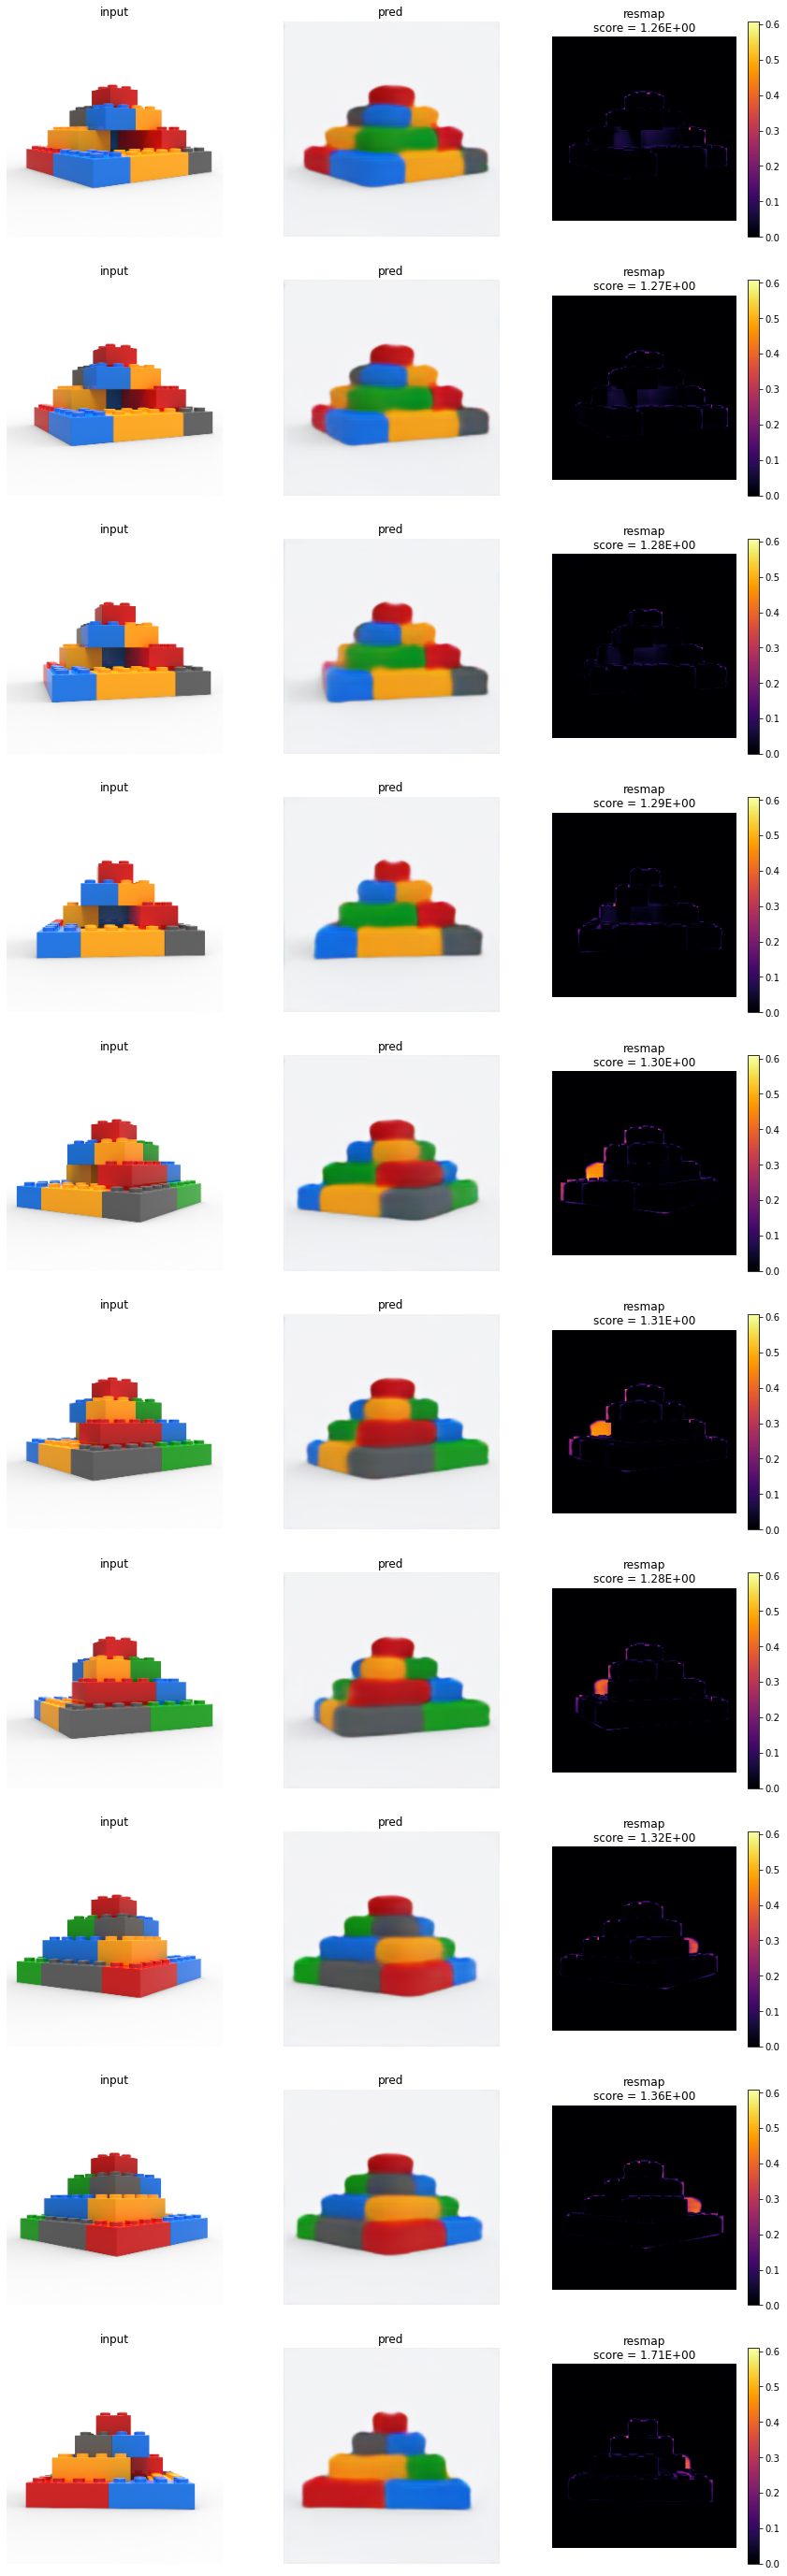

In [40]:
tensor_test_l2.generate_inspection_figure(filenames_plot=list_B_missing_sv)

### Anomaly type: shifted Lego-Brick

In [41]:
list_B_shifted_sv = [
    "B_shifted_sv/010.png",
    "B_shifted_sv/030.png",
    "B_shifted_sv/040.png",
    "B_shifted_sv/100.png",
    "B_shifted_sv/200.png",
    "B_shifted_sv/230.png",
]

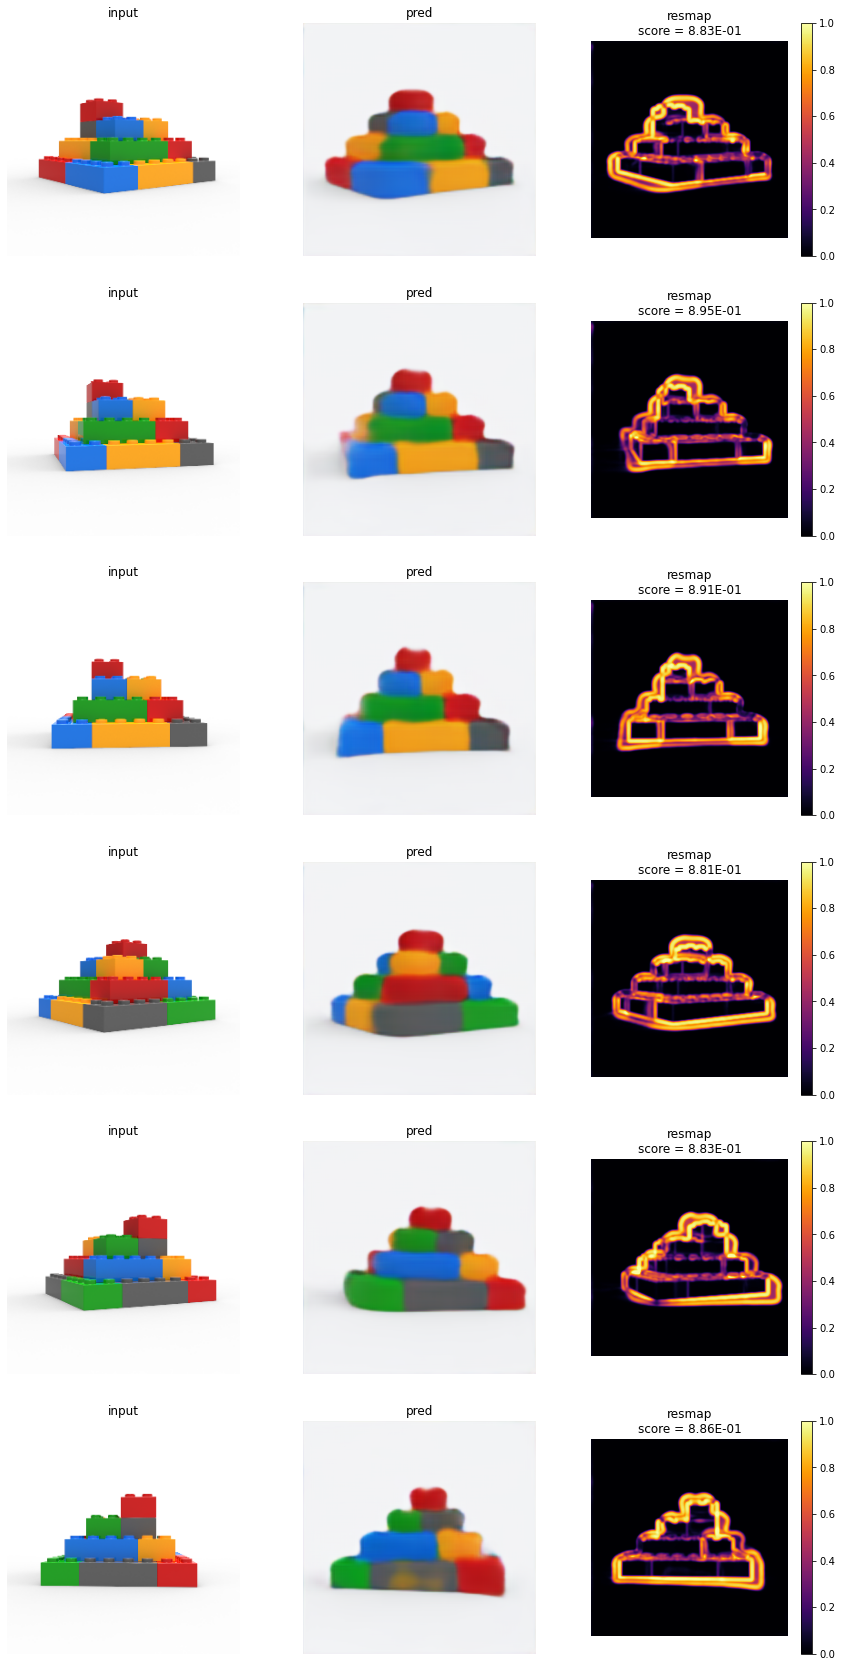

In [42]:
tensor_test_ssim.generate_inspection_figure(filenames_plot=list_B_shifted_sv)

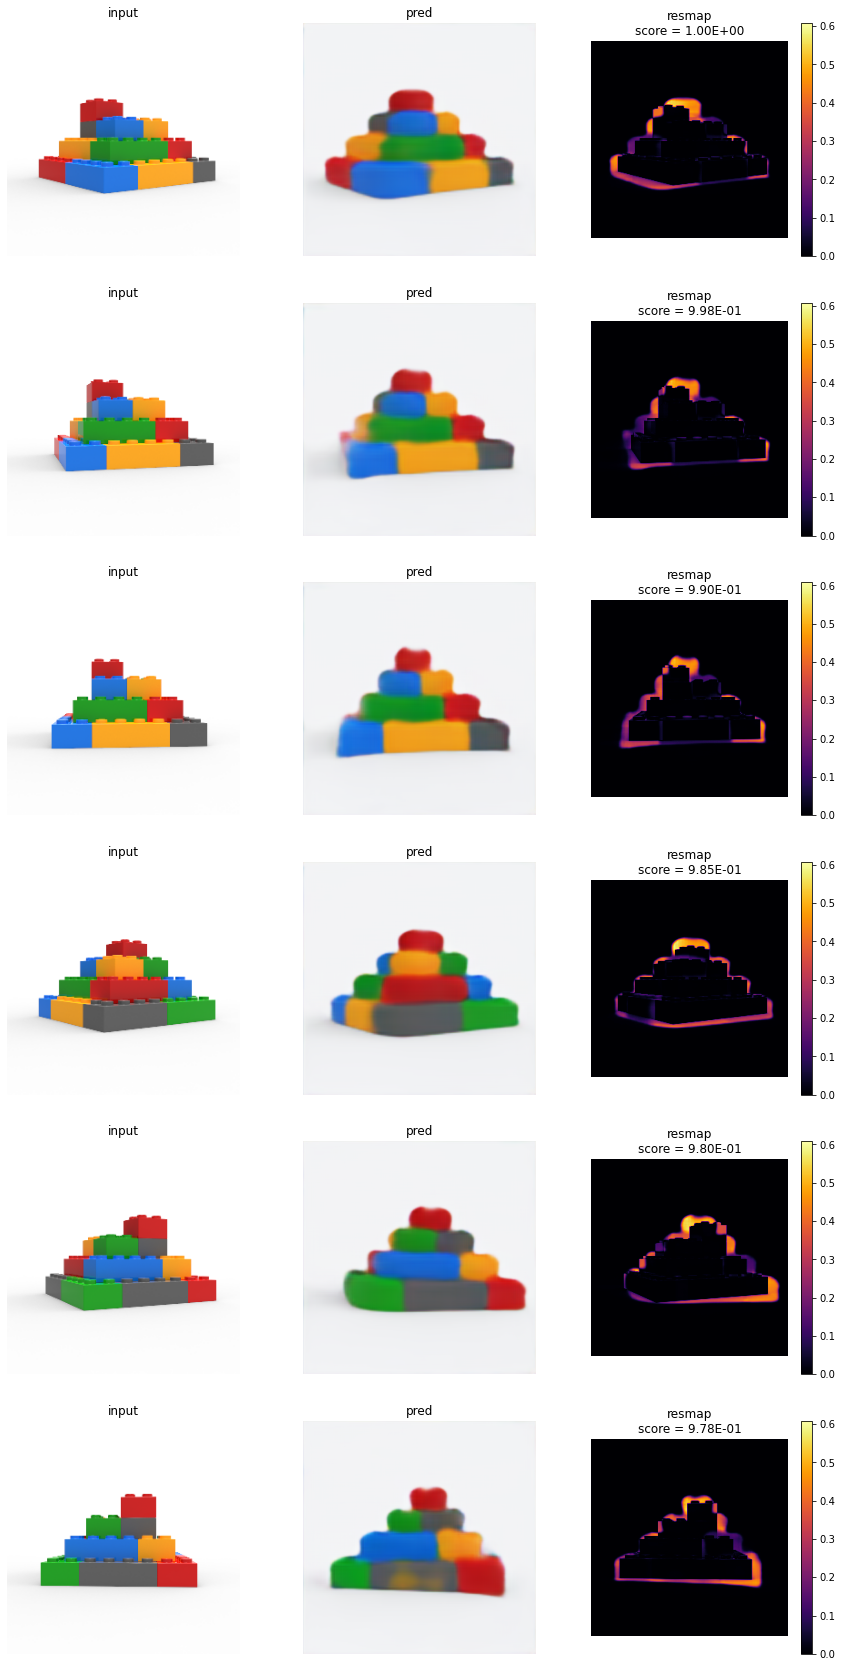

In [43]:
tensor_test_l2.generate_inspection_figure(filenames_plot=list_B_shifted_sv)

### Anomaly type: false color 1 Lego-Brick

In [44]:
list_C_color_1_sv = [
    "C_color_1_sv/020.png",
    "C_color_1_sv/050.png",
    "C_color_1_sv/110.png",
]

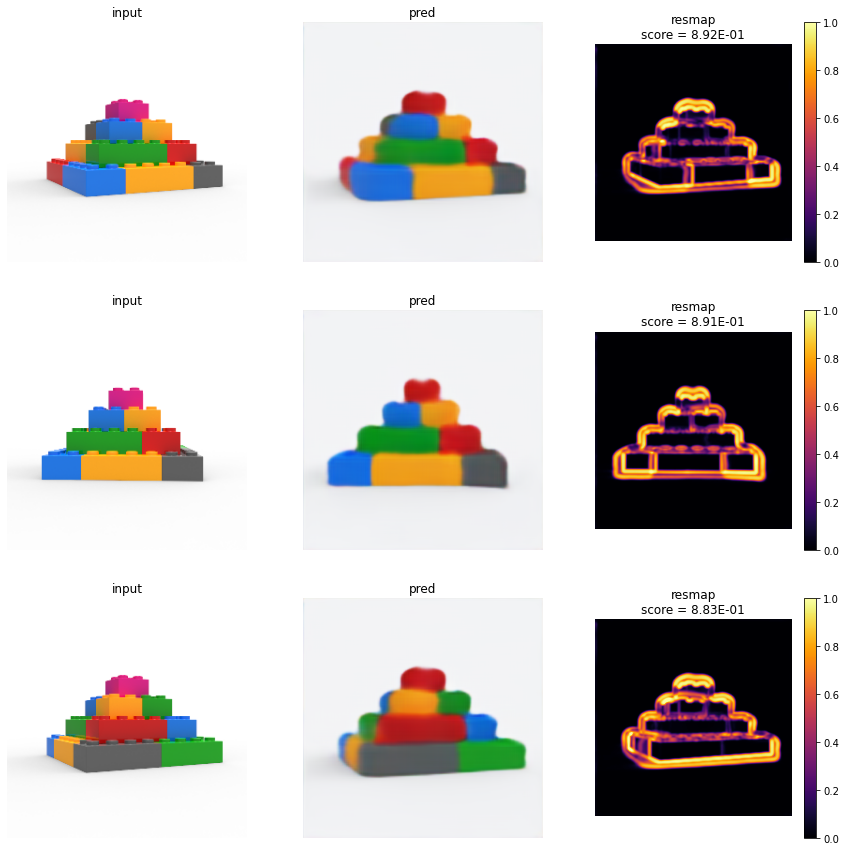

In [45]:
tensor_test_ssim.generate_inspection_figure(filenames_plot=list_C_color_1_sv)

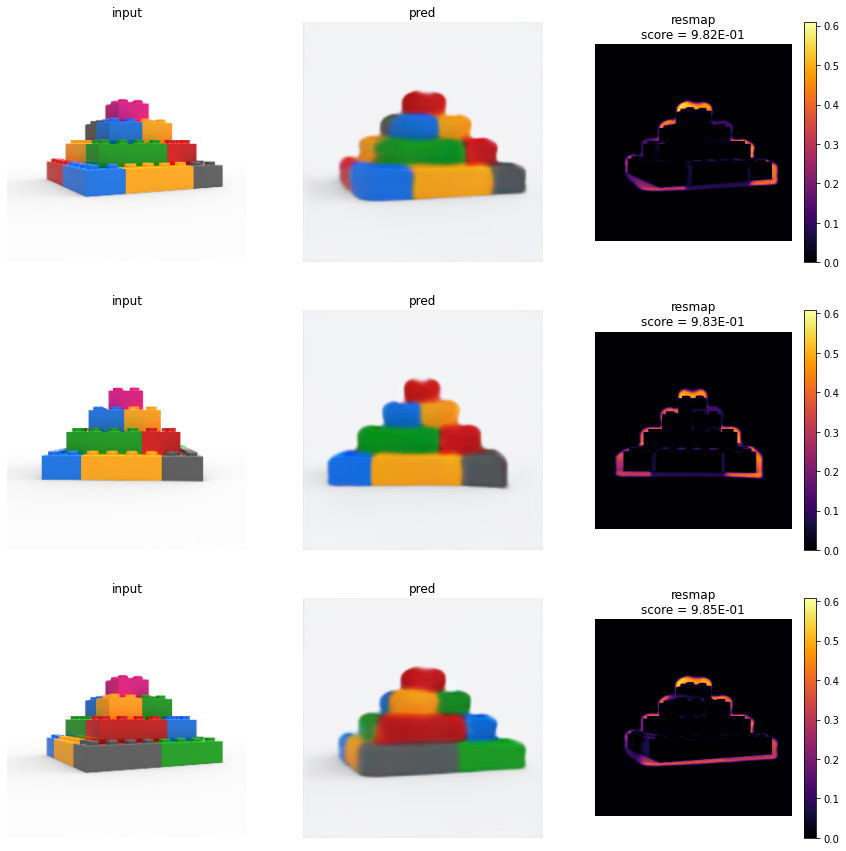

In [46]:
tensor_test_l2.generate_inspection_figure(filenames_plot=list_C_color_1_sv)

### Anomaly type: false color 2 Lego-Brick

In [47]:
list_C_color_2_sv = [
    "C_color_2_sv/010.png",
    "C_color_2_sv/030.png",
    "C_color_2_sv/080.png",
]

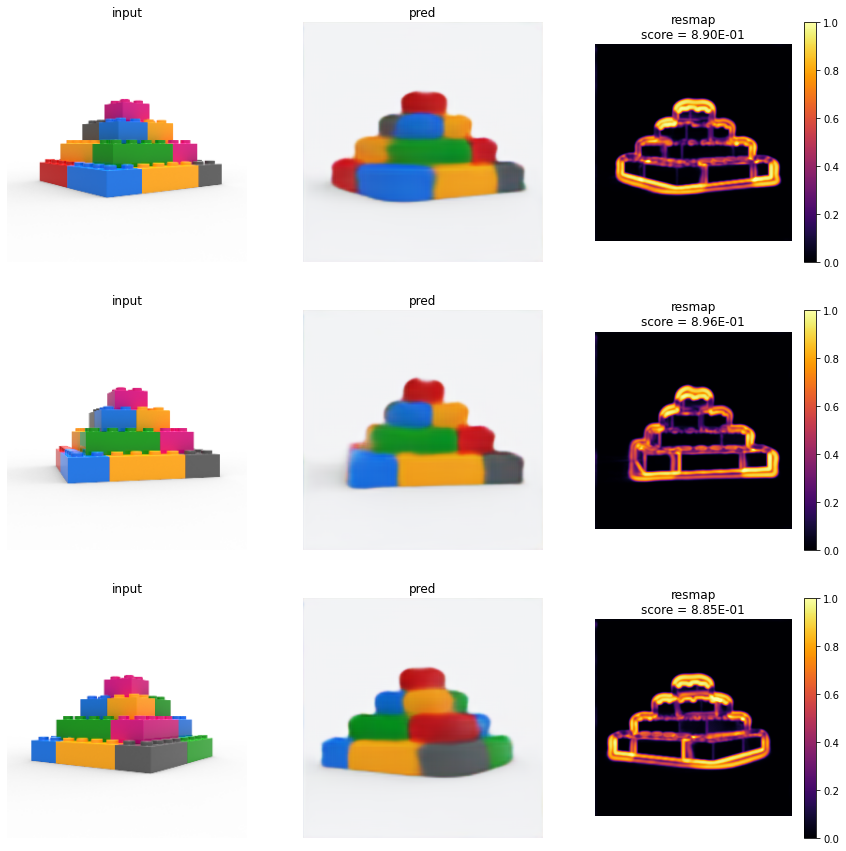

In [48]:
tensor_test_ssim.generate_inspection_figure(filenames_plot=list_C_color_2_sv)

### Anomaly type: false color 3 Lego-Brick

In [49]:
list_C_color_3_sv = [
    "C_color_3_sv/001.png",
    "C_color_3_sv/010.png",
    "C_color_3_sv/180.png",
]

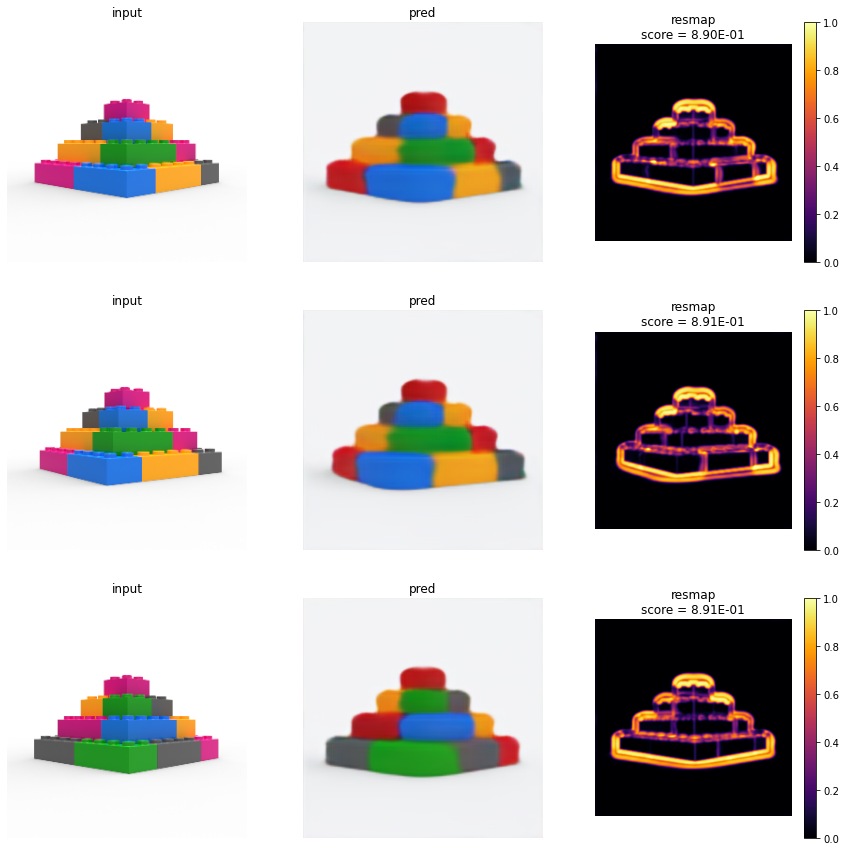

In [50]:
tensor_test_ssim.generate_inspection_figure(filenames_plot=list_C_color_3_sv)

In [ ]:
# def get_scores_by_category(self, generator):
#     scores_dict = dict()
#     for category in list(generator.class_indices.keys()):
#         indicies_cat = np.nonzero(
#             generator.classes == generator.class_indices[category]
#         )
#         scores_dict[category] = self.scores[indicies_cat]
#     return scores_dict